In [1]:
import numpy as np
import tarfile
import xarray as xr
import io
import tempfile
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
import radar
import pyart
import sys
sys.path.append('/Users/robbyfrost/Documents/MS_Project/TurbTor_Radar/')
from functions import *

# plotting set up
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
rc('font', family='sans-serif')
rc('font', weight='normal', size=15)
rc('figure', facecolor='white')

# read radar data with pyart
drad = "/Users/robbyfrost/Documents/MS_Project/data/RaXPol/20250226/"
frad = "RAXPOL-20250226-200942-E3.0.nc.tar.xz"
with tarfile.open(drad + frad, 'r:xz') as tar:
    nc_file = tar.extractfile(frad[:-7])
    nc_data = io.BytesIO(nc_file.read())
with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
    tmp_file.write(nc_data.getvalue())
    tmp_file_path = tmp_file.name
radar = pyart.io.read(tmp_file_path)
# arrays
radswp = radar.extract_sweeps([0])
vr = radswp.fields['VEL']['data']
vr_da = xr.DataArray(vr, dims=["az", "r"])
vr = vr_da.rolling(az=3,r=3, center=True).mean().values
vr = np.ma.masked_invalid(vr)
az = radswp.azimuth['data']
r = radswp.range['data']
el = radswp.elevation['data']
# calculate vorticity
vortz = np.zeros_like(vr)
vortz[1:, :] = ( (vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis] ) * (1 / r)
vortz_field = {
    'data': vortz,
    'units': '/s',
    'long_name': 'Inferred Vertical Vorticity',
    'standard_name': 'Inferred vertical vorticity',
}
radswp.add_field('vortz', vortz_field)

# # read in radar file
# drad = "/Users/robbyfrost/Documents/MS_Project/data/RaXPol/"
# frad = "RAXPOL-20250226-201312-E3.0.nc.tar.xz"
# with tarfile.open(drad + frad, 'r:xz') as tar:
#     nc_file = tar.extractfile(frad[:-7])
#     nc_data = io.BytesIO(nc_file.read())
# ds = xr.open_dataset(nc_data)
# ds = ds.where(ds.DBZ > -10, drop=False)
# arrays
# z = ds.DBZ.values
# vr = ds.VEL.values
# az = ds.azimuth.values
# r = ds.range.values
# time_start = str(ds.time_coverage_start.values)[2:-13]
# time_end = str(ds.time_coverage_end.values)[2:-13]
# # inferred vorticity
# vortz = ((vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis]) * (1 / r)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# # more basic read in method
# radar = radar.read(drad+frad)

# kind = radar['kind']
# txrx = radar['txrx']
# time = radar['time']
# lat = radar['latitude']
# lon = radar['longitude']
# swpEl = radar['sweepElevation']
# swpAz = radar['sweepAzimuth']
# prf = radar['prf']
# waveform = radar['waveform']
# gatewidth = radar['gatewidth']
# el = radar['elevations']
# az = radar['azimuths']
# r = radar['ranges']
# products = radar['products']

# z = products['Z']
# vr = products['V']
# W = products['W']
# D = products['D']
# P = products['P']
# R = products['R']

# vortz = ((vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis]) * (1 / r)

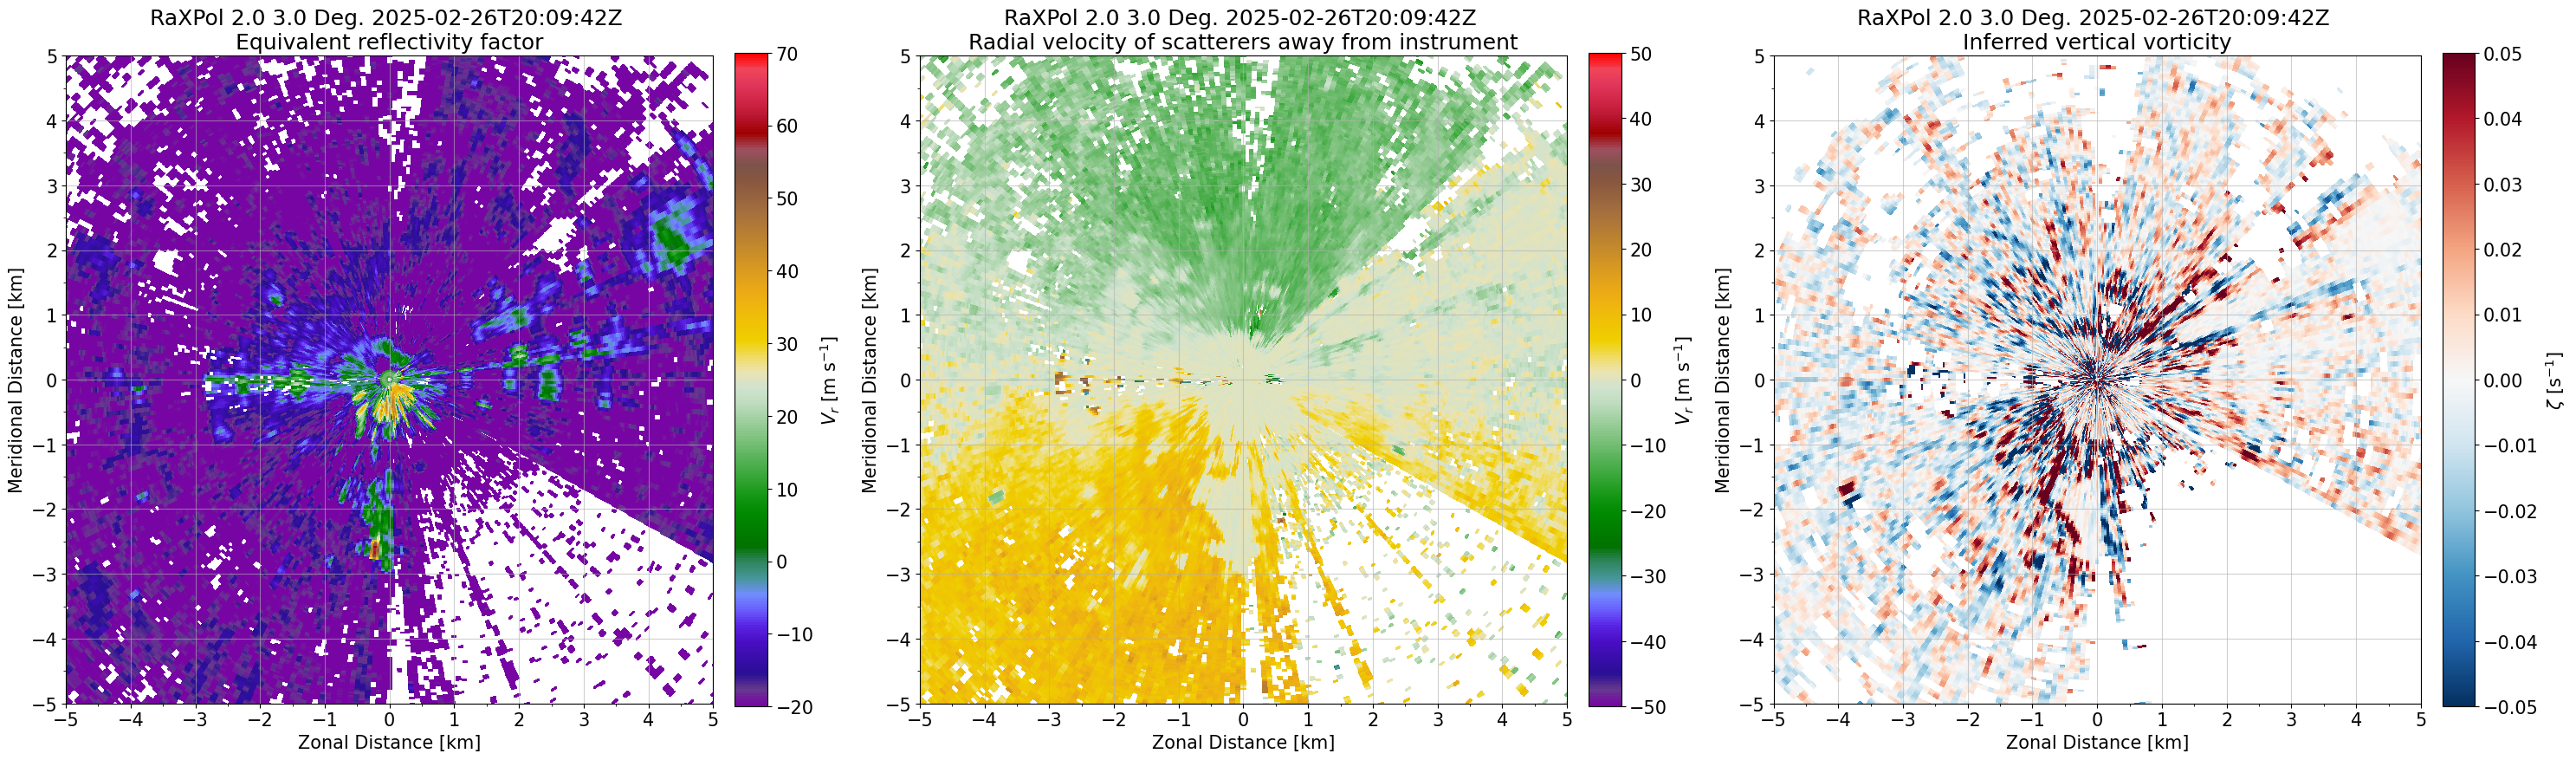

In [5]:
display = pyart.graph.RadarDisplay(radswp)

fig, ax = plt.subplots(figsize=(30, 10), ncols=3)

# reflectivity
vmin, vmax = -20, 70
display.plot_ppi('DBZ', ax=ax[0], 
                vmin=vmin, vmax=vmax,
                cmap="Carbone42",
                colorbar_flag=False,
                title_use_sweep_time=True,
                axislabels_flag=False)
cbar1 = fig.colorbar(display.plots[0], ax=ax[0], aspect=20, pad=0.03, fraction=0.06, shrink=0.79)
cbar1.set_label("$V_r$ [m s$^{-1}$]")
cbar1.set_ticks(np.arange(vmin, vmax + 0.001, 10))

# radial velocity
vmin, vmax = -50, 50
display.plot_ppi('VEL', ax=ax[1], 
                vmin=vmin, vmax=vmax,
                cmap="Carbone42",
                colorbar_flag=False,
                title_use_sweep_time=True,
                axislabels_flag=False)
cbar1 = fig.colorbar(display.plots[1], ax=ax[1], aspect=20, pad=0.03, fraction=0.06, shrink=0.79)
cbar1.set_label("$V_r$ [m s$^{-1}$]")
cbar1.set_ticks(np.arange(vmin, vmax + 0.001, 10))

# inf vertical vorticity
vmin, vmax = -0.05, 0.05
display.plot_ppi('vortz', ax=ax[2], 
                vmin=vmin, vmax=vmax,
                cmap="RdBu_r", 
                colorbar_flag=False,
                title_use_sweep_time=True,
                axislabels_flag=False)
# display.plot_range_rings(r[ridx]/1e3, ax=ax[2], ls='--', lw=1, col='black')
cbar1 = fig.colorbar(display.plots[2], ax=ax[2], aspect=20, pad=0.03, fraction=0.06, shrink=0.79)
cbar1.set_label("$\\zeta$ [s$^{-1}$]")
cbar1.set_ticks(np.arange(vmin, vmax+0.001, 0.01))

# # title
# scan_time = radar.time['units'].split(' ')[-1]
# elevation_angle = radar.fixed_angle['data'][swp]
# fig.suptitle(f"{scan_time}, Elevation = {elevation_angle:.2f}°", fontsize=30, fontweight='bold', y=0.95)

for iax in ax:
    iax.set_aspect('equal')
    iax.set_xlim(-5,5)
    iax.xaxis.set_major_locator(MultipleLocator(1))
    iax.xaxis.set_minor_locator(MultipleLocator(0.5))
    iax.set_xlabel("Zonal Distance [km]")
    iax.set_ylim(-5,5)
    iax.yaxis.set_major_locator(MultipleLocator(1))
    iax.yaxis.set_minor_locator(MultipleLocator(0.5))
    iax.set_ylabel("Meridional Distance [km]")
    iax.grid(alpha=0.6)

fig.tight_layout()

plt.show()
plt.close(fig)